In [ ]:
%reset

In [1]:
ForColab = False

In [2]:
if ForColab:
    !pip install wget
    import plotly.io as pio
    pio.renderers.default = 'colab'
else:
    print("Working local")

Working local


In [3]:
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
         'axes.labelsize': 13,
         'axes.titlesize':13,
         'xtick.labelsize':13,
         'ytick.labelsize':13,
         'axes.labelweight':'bold',
          'legend.fontsize': 13,
         'figure.max_open_warning': 0}
         
plt.rcParams.update(params)

In [312]:
from datetime import datetime, timedelta
import os
from pathlib import Path
import pickle
from timeit import default_timer as timer
import wget
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
    
import pandas as pd
pd.options.plotting.backend = "plotly"

import numpy as np

from tqdm.notebook import tqdm

from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize,curve_fit

from sklearn.metrics import mean_squared_log_error, mean_squared_error

from PIL import Image

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import pyross
import pyrossgeo

['/Users/nadeem/py3_kernel/lib/python3.8/site-packages/pyrossgeo']

In [5]:
def plot_model(Data,  ICUHospital, title):

    S  = model.S(Data)
    Ia = model.Ia(Data)
    Is = model.Is(Data)
    R  = model.R(Data)

    InfectedCases = Ia+Is

    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
    fig, ax1 = plt.subplots(1, 1)
    fig.suptitle(title)

    ax1.plot(S, 'tab:blue', label='Susceptible');
    ax1.plot(Ia, 'tab:orange', label='Exposed');
    ax1.plot(Is, 'tab:red', label='Infected');
    ax1.plot(R, 'tab:green', label='Recovered');
    #ax1.plot(InfectedCases, 'tab:purple', label='Hospitalised');
    #ax1.plot(crit, 'tab:brown', label='Critical');
    #ax1.plot(death, 'tab:cyan', label='Deceased');
    #ax1.hlines(np.mean([SAHospital[1][0],SAHospital[1][1]]),0,len(sus),linestyles='dashed',
    #           label="Mean ICU beds")


    ax1.semilogy()

    ax1.set_xlabel("Days");
    ax1.legend(loc='best');
    ax1.set_ylabel("No of people");
    '''        
    ax2.plot(cases, 'tab:red', label='Cases');    
    ax2.set_xlabel("Days", fontsize=10);
    ax2.semilogy()

    ax3 = ax2.twinx()
    ax3.plot(death, 'tab:cyan', label='Deceased');    
    ax3.set_xlabel("Days", fontsize=10);
    ax3.semilogy()
    '''

    '''
    ax2.set_ylabel("No of population (Cases)", fontsize=10, color='tab:red');
    ax3.set_ylabel("No of population (Fatalities)", fontsize=10, color='tab:cyan');
    '''        

    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),ncol=3, fancybox=True, shadow=True)

In [6]:
NZA = 59156682 # Total South Africa population

# Getting some values for cases in SA for each province 

In [75]:
def get_SA_province(ToUpdateSAProvince):
    
    '''
    Usage:
    
        get_SA_province('y') or get_SA_province('n')
    
    This function will get the SA provincial confirmed and cases as function of date
    It also has the total that should agree with the reported worldodometer confirmed cases
    
    Input:
        Take a y or n - whether to update the dataset or not
    
    Output:
        Returns the SA province confirmed dataframe
    '''
    
    import pandas as pd
    import wget
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context

    if ToUpdateSAProvince.lower() =='y':
        
        print("updating data")
        ConfirmedURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
        SAProvinConfirmed = pd.read_csv(wget.download(ConfirmedURL))
        DeathURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv"
        SAProvinDead = pd.read_csv(wget.download(DeathURL))
        RecoveredURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv"
        SAProvinrecover = pd.read_csv(wget.download(DeathURL))
        
    else:
        print("Reading local file... Please check data is uptodate")
        SAProvinConfirmed  = pd.read_csv("covid19za_provincial_cumulative_timeline_confirmed.csv")
        SAProvinDead = pd.read_csv("covid19za_provincial_cumulative_timeline_deaths.csv")
        SAProvinrecover = pd.read_csv("covid19za_provincial_cumulative_timeline_recoveries.csv")
        print(f"Note: File was last updated on {SAProvinConfirmed['date'].values[-1]}")
    #
    # Drop the unwanted column
    #
    if 'YYYYMMDD' in SAProvinConfirmed.columns:
        SAProvinConfirmed.drop(columns='YYYYMMDD', inplace = True)
        SAProvinDead.drop(columns='YYYYMMDD', inplace = True)
        SAProvinrecover.drop(columns='YYYYMMDD', inplace = True)
    #
    # Drop the source of information
    #
    if 'source' in SAProvinConfirmed.columns:
        SAProvinConfirmed.drop(columns='source', inplace = True)
        SAProvinDead.drop(columns='source', inplace = True)
        SAProvinrecover.drop(columns='source', inplace = True)
    #
    # Make the date the index
    #
    SAProvinConfirmed["date"] = pd.to_datetime(SAProvinConfirmed.date, format='%d-%m-%Y')
    SAProvinConfirmed.index = SAProvinConfirmed["date"]
    
    SAProvinDead["date"] = pd.to_datetime(SAProvinDead.date, format='%d-%m-%Y')
    SAProvinDead.index = SAProvinDead["date"]
    
    SAProvinrecover["date"] = pd.to_datetime(SAProvinrecover.date, format='%d-%m-%Y')
    SAProvinrecover.index = SAProvinrecover["date"]
    
    #
    # Deleting the date column now
    #
    SAProvinConfirmed.drop(columns='date', inplace = True)
    SAProvinDead.drop(columns='date', inplace = True)
    SAProvinrecover.drop(columns='date', inplace = True)
    #
    # Renaming the Total column to Confirmed
    #
    SAProvinConfirmed = SAProvinConfirmed.rename(columns={'total': 'Confirmed'})
    SAProvinDead = SAProvinDead.rename(columns={'total': 'Dead'})
    SAProvinrecover = SAProvinrecover.rename(columns={'total': 'Recovered'})
    #
    #
    #
    return(SAProvinConfirmed,SAProvinDead, SAProvinrecover)



In [76]:
ProvinConf, ProvinDead, ProvinRecover = get_SA_province('y') 

updating data


In [77]:
ProvinConf.head()

,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,Confirmed
date,,,,,,,,,,,
2020-03-05,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2020-03-07,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2020-03-08,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2020-03-09,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2020-03-11,0.0,0.0,5.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,13


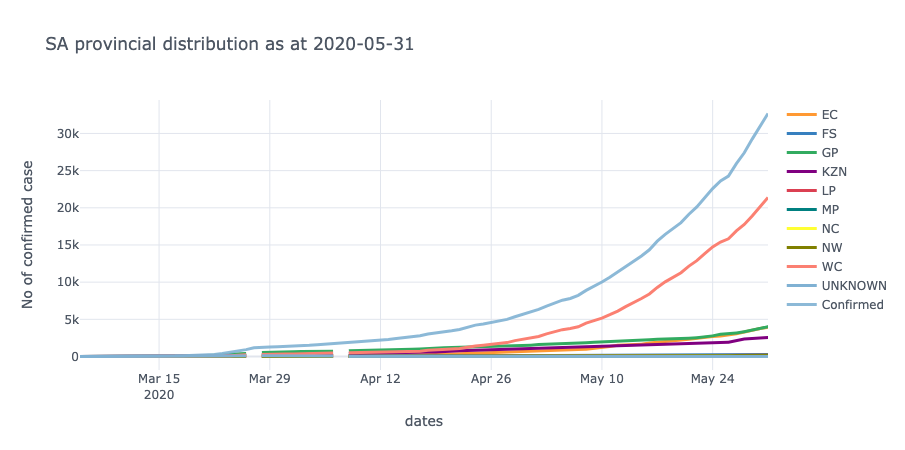

In [78]:
ProvinConf.iplot(theme="white",xTitle = "dates",yTitle="No of confirmed case",width=3,
                        title=f"SA provincial distribution as at {ProvinConf.index[-1].date()}")


In [262]:
# ZA province population 

In [263]:
def get_SA_Prov_Pop(ToUpdateSAProvince):
    
    '''
    Usage:
    
        get_SA_province('y') or get_SA_province('n')
    
    This function will get the SA provincial population numbers.
    
    Input:
        Take a y or n - whether to update the dataset or not
    
    Output:
        Returns the SA province population dataframe
    '''
    
    import pandas as pd
    import wget
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context

    if ToUpdateSAProvince.lower() =='y':
        
        print("updating data")
        ConfirmedURL = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/za_province_pop.csv'
        SAProvinPop = pd.read_csv(wget.download(ConfirmedURL),header=None)
        SAProvinPop.columns = ['Province', 'Pop']

    return(SAProvinPop)


In [264]:
SAProvPop = get_SA_Prov_Pop('y')

updating data


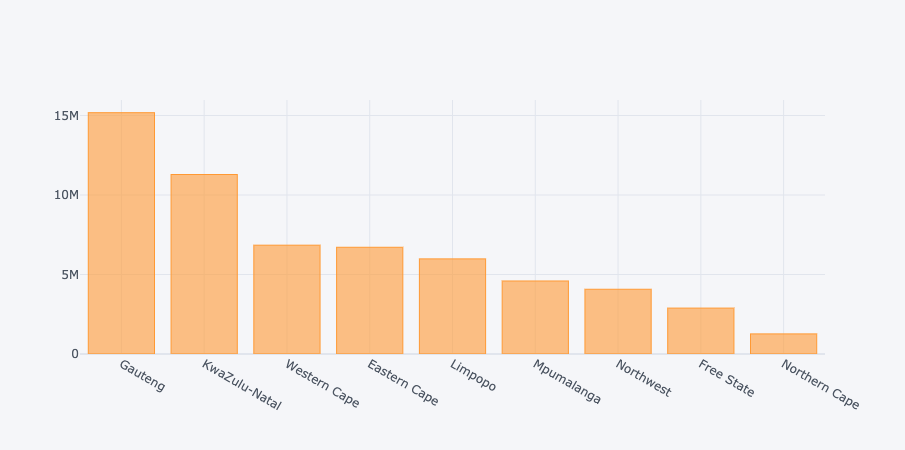

In [265]:
SAProvPop.iplot(kind='bar',x='Province',y='Pop')

# SEAI8R

In [266]:
## Description of this model 


![Screenshot_2020-05-13_at_13.54.00](https://gitlab.com/camsofties/covid19//uploads/55279e434788919018151d4793bb11f0/Screenshot_2020-05-13_at_13.54.00.png)


In this model we are still using an SIR except that we added an Exposed (E), Activated (A) compartment.

- The activated compartment holds the population of cases that are asymptomatic and infectious.

The following parameters are used in this model:

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), 
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals), 
* $\gamma_\mathrm{E}$ (rate of exposed -> activated), 
* $\gamma_\mathrm{A}$ (rate of activated -> infected, symptomatic or asymptomatic)
* $\mathrm{hh}$ (rate of infected -> hospitalised)


In [267]:
#
# Doing a more complex model now pyross.deterministic.SEAI8R
#

# 1 - Define model

In [268]:
PyROSSPATH = pyross.__path__[0]

In [269]:
PyROSSAgePATH = PyROSSPATH[:-6]+'examples/data/age_structures/'

## 1.1 - Set up age group

In [270]:
def AgeClass(AgeMat, ToDoAge):
    '''
    This function will return the Age matrix
    Input:
        M - number of age classes
        AgeMat - matrix holding the age classes
    OutPut:
        N - total population is the size of this age group
    '''
    #
    # population and age classes
    #
    if ToDoAge:

        print("#####\n Age classes has been selected \n#####")
        M     = len(AgeMat)                           # number of age classes, here taking all 21
        Ni    = AgeMat['M'].values+AgeMat['F'].values # aM, aF - age male and age female
        Ni    = Ni[0:M]                               # Give the total population in each age group
        N     = np.sum(Ni)                            # Getting the total population of country

    else:
        print("#####\n NO age classes has been selected \n#####")
        M     = 1                                     # Number of compartments of individual for each class,
                                                      # the SIR model has no age structure for now
        Ni    = NZA*np.ones(M)                        # Initial number in each compartment and class
        N     = np.sum(Ni)                            # and the total population is the size of this age group
    
    return(M, Ni)

In [271]:
AgeZA = pd.read_csv(PyROSSAgePATH+'SouthAfrica-2019.csv')

M, Ni = AgeClass(AgeZA, False)

#####
 NO age classes has been selected 
#####


## 1.2 - Set up the contact Matrix

In [272]:
ToDoContact = False
#
# ToDo a contactmatrix for SouthAfrica provinces
#
# pyross.contactMatrix.ContactMatrixFunction?
# CH:  constant matrix at home
# CW:  constant matrix at work
# CS:  constant matrix at school
# CO:  constant matrix at other locations
#

Tf = 240                              # reference trajectory is 240 days long
Nf = 600                     
times = [21, Tf]                      # temporal boundaries between different contact-behaviour


if ToDoContact:
    #
    # Get individual contact matrices
    #
    CH, CW, CS, CO = pyross.contactMatrix.India()
    #
    # Generate class with contact matrix for SIR model with UK contact structure
    #
    generator = pyross.contactMatrix.ContactMatrixFunction(CH, CW, CS, CO)

    aW, aS, aO = 0.3, 0.2, 0.8

    # prefactors for CW, CS, CO:
    interventions = [[1.0,1.0,1.0],      # before first time
                     [aW, aS, aO],       # between first and second time
                    ]         

    # generate corresponding contact matrix function
    contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)
    
else:
    def contactMatrix(t):   
        return np.identity(M)

## 1.3 - Parameters of trajectory

In [273]:
#
# Model parameters set up
#
alpha = 0.75                 # fraction of infected who are asymptomatic

#beta  = 0.5                # Uncomment to use infection rate for South Africa from 
                            # https://www.medrxiv.org/content/10.1101/2020.04.18.20070771v2
                            # beta = Rt/tinf
Rt    = 2.4                 # using the value we used in our original model
tinf  = 6.1                 # infectious time
beta  = Rt/tinf

#gE    = 1./2.72            # rate of removal of Exposed
gE    = 1./5.1              # rate of removal of Exposed, aka 1/t_incu 
gA    = 1./3.12             # rate of removal of Activated
gIa   = 1./7.               # rate of removal of asymptomatic infectives 
gIs   = 1./4.82             # rate of removal of symptomatic infectives 

fsa   = 1.                  # the self-isolation parameter   
fh    = 0.2                 # fraction by which hospitalised individuals are isolated
gIh   = 1./10.              # rate of removal for hospitalised individuals
gIc   = 1./10.              # rate of removal for idividuals in intensive care
 
gIsp  = 1./7.               # rate of removal from symptomatic individuals towards buffer
gIhp  = 1./7.               # rate of removal from hospitalised individuals towards buffer
gIcp  = 1./7.               # rate of removal from ICU individuals towards buffer

sa   = 0.2*np.ones(M)       # daily arrival of new susceptables - 
                            # sa is rate of additional/removal of population by birth etc
hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction sent to ICU from hospitalised
mm   = 0.8*np.ones(M)       # mortality rate in ICU, aka IFR !!!



## 1.4 - Initial conditions    


In [274]:

DateToStart = '2020-05-01'     # Date to start the prediction 


In [275]:

#E_0   = np.zeros((M))

A_0   = np.zeros((M))

#Ia_0  = 1000*np.ones((M))            # assume 1000 asymptomatic cases 
                                      # 5-80% https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/
frac_asymptomatic = alpha
#n_tested_active   = 4502              # total cases - recovered: 5951 - 2498
n_tested_active   = ProvinConf[ProvinConf.index == DateToStart]['Confirmed'].values[0]- \
                    ProvinRecover[ProvinRecover.index == DateToStart]['Recovered'].values[0]
Ia_0              = (n_tested_active * (1/(1-frac_asymptomatic)))*np.ones((M)) 


E_0   = Ia_0 * 1.7                     # (R_t^(time from infection to test)/t_inf ~ 2)*n_infected

#Is_0  = np.zeros((M))                 # initial symptomatic cases
Is_0  = ProvinConf[ProvinConf.index == DateToStart]['Confirmed'].values[0]*np.ones((M))

Isp_0 = np.zeros((M))

#Ih_0  = np.zeros((M))                 # initial hospitalised cases
Ih_0  = 140*np.ones((M))               # can put each province number hereon
Ihp_0 = np.zeros((M))

#Ic_0  = np.zeros((M))                 # initial icu patients
Ic_0  = 70*np.ones((M))                # can put each province number hereon
Icp_0 = np.zeros((M))

#Im_0  = np.zeros((M))                 # initial mortality cases
Im_0  = ProvinDead[ProvinDead.index == DateToStart]['Dead'].values[0]*np.ones((M))

#R_0   = np.zeros((M))                 # assume no removed individuals
#n_recovered = (n_total_cases - n_tested_active) * (1/(1-frac_asymptomatic))
R_0   = (ProvinConf[ProvinConf.index == DateToStart]['Confirmed'].values[0] - n_tested_active)*\
        (1/(1-frac_asymptomatic))*np.ones(M)

S_0   = Ni - (E_0 + A_0 + Ia_0 + Is_0 + Isp_0+ Icp_0+ Ihp_0 + Ih_0 + Ic_0  + R_0)


# 2 - Use pyross to generate model

- In or model we are interested in the population of cases which are critical, we can either use a SEAI8R or SEA5IR
- The major differences is that the SEAI8R model has 3 ganular compartments of Symptomatic, Hospitalised and ICU
cases that recover. Each will have a separate compartment.

- We will look at both the SEAI8R and SEAI5R model

## 2.1 - SEAI8R model

In [300]:
#
# intantiate model
#
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 'gIsp':gIsp, 'gIcp':gIcp, 'gIhp':gIhp,
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.deterministic.SEAI8R(parameters, M, Ni)
data  = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Isp_0, Ih_0, 
                       Ih_0, Ic_0, Icp_0, Im_0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('Deterministic_Trajectory.npy', data_array) # this is needed in the inference part later

## 2.1.1 - Intermediate SEAI8R visualization

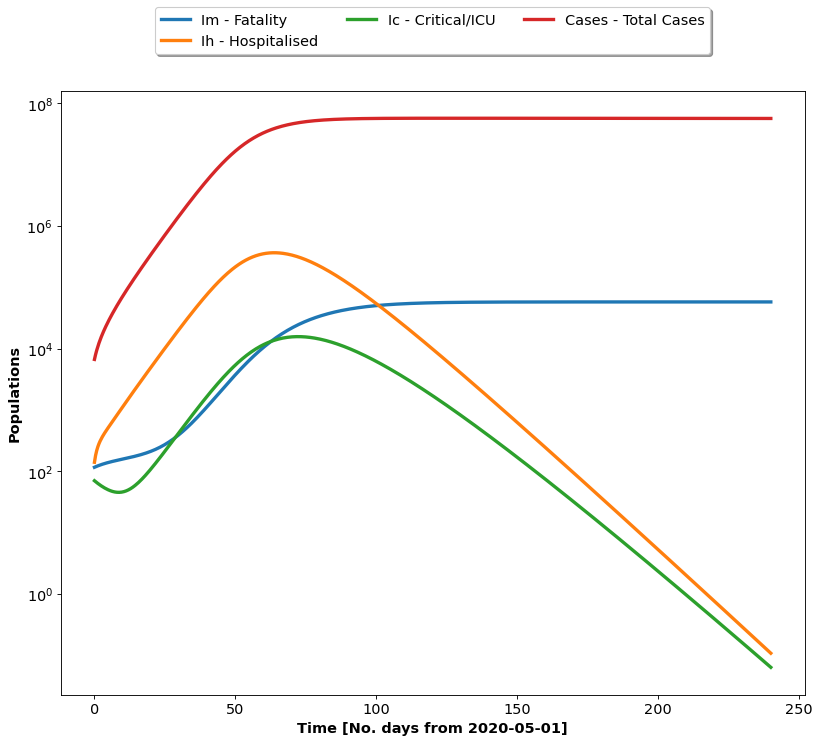

In [306]:
#
# plot the stochastic solution 
#
fig,ax = plt.subplots(1,1, dpi=80, facecolor='w', edgecolor='k')

S = model.S(data);
E = model.E(data);
A = model.A(data);

Ia = model.Ia(data);
Is = model.Is(data);
Im = model.Im(data);
Ih = model.Ih(data);
Ic = model.Ic(data);

Itotal = Ia+Is

R = model.R(data);

#cases = (inf + rec + hosp + crit + death)
TotalCases = (Is + R + Ih + Im)

#ax.plot(data['t'], S.sum(axis=1), lw=3, label='S - Suceptible')
#ax.plot(data['t'], E.sum(axis=1), lw=3, label='E - Exposed')
#ax.plot(data['t'], A.sum(axis=1), lw=3, label='A - Activated')
#ax.plot(data['t'], Ia.sum(axis=1), lw=3, label='Ia - Infected Asymptomatic')
#ax.plot(data['t'], Is.sum(axis=1), lw=3, label='Is - Infected Symptomatic')
ax.plot(data['t'], Im.sum(axis=1), lw=3, label='Im - Fatality')
ax.plot(data['t'], Ih.sum(axis=1), lw=3, label='Ih - Hospitalised')
ax.plot(data['t'], Ic.sum(axis=1), lw=3, label='Ic - Critical/ICU')
#ax.plot(data['t'], Itotal.sum(axis=1), lw=3, label='It - Total Infected')
#ax.plot(data['t'], R.sum(axis=1), lw=3, label='R - Total Recovered')
ax.plot(data['t'], TotalCases.sum(axis=1), lw=3, label='Cases - Total Cases')


ax.set_xlabel(f"Time [No. days from {DateToStart}]")
ax.set_ylabel('Populations')
#ax.set_title('SEAI8R model')

#ax2 = ax.twiny()
#ax2.set_xlabel("Date")
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=3, fancybox=True, shadow=True)
plt.semilogy()
plt.savefig('PyROSS_SEAI8R_SEIRHCD.png')
plt.show()
plt.close()

## 2.2 - SEAI5R model

In [303]:
#
# intantiate model
#
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 'gIsp':gIsp, 'gIcp':gIcp, 'gIhp':gIhp,
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.deterministic.SEAI5R(parameters, M, Ni)
data  = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SEAI5R_Deterministic_Trajectory.npy', data_array) # this is needed in the inference part later

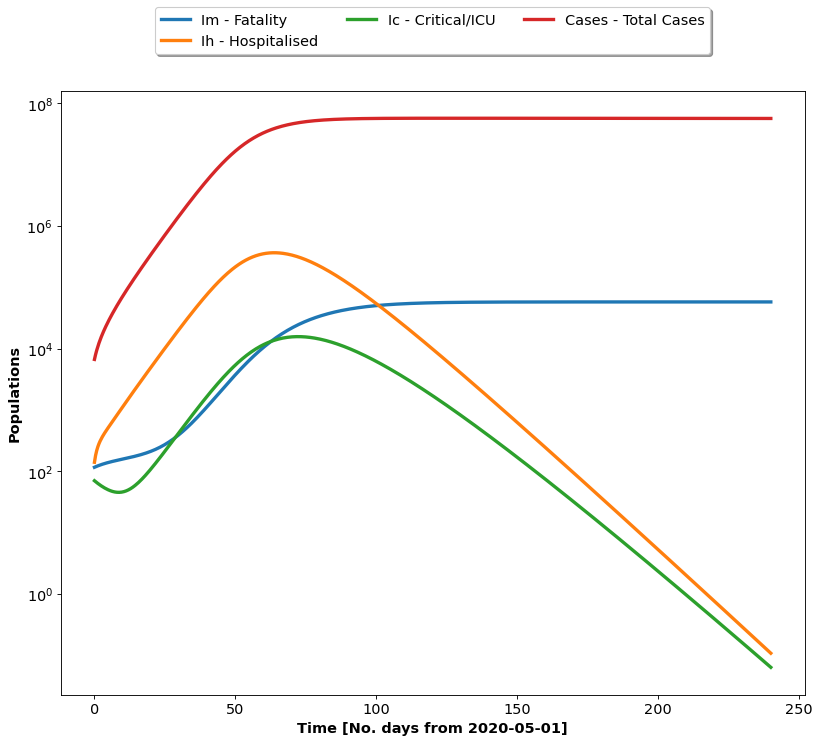

In [305]:
#
# plot the stochastic solution 
#
fig,ax = plt.subplots(1,1, dpi=80, facecolor='w', edgecolor='k')

S = model.S(data);
E = model.E(data);
A = model.A(data);

Ia = model.Ia(data);
Is = model.Is(data);
Im = model.Im(data);
Ih = model.Ih(data);
Ic = model.Ic(data);

R = model.R(data);
#
# TotalCases = (inf + rec + hosp + crit + death)
#
TotalCases = (Is + R + Ih + Im)

#ax.plot(data['t'], S.sum(axis=1), lw=3, label='S - Suceptible')
#ax.plot(data['t'], E.sum(axis=1), lw=3, label='E - Exposed')
#ax.plot(data['t'], A.sum(axis=1), lw=3, label='A - Activated')
#ax.plot(data['t'], Ia.sum(axis=1), lw=3, label='Ia - Infected Asymptomatic')
#ax.plot(data['t'], Is.sum(axis=1), lw=3, label='Is - Infected Symptomatic')
ax.plot(data['t'], Im.sum(axis=1), lw=3, label='Im - Fatality')
ax.plot(data['t'], Ih.sum(axis=1), lw=3, label='Ih - Hospitalised')
ax.plot(data['t'], Ic.sum(axis=1), lw=3, label='Ic - Critical/ICU')
#ax.plot(data['t'], Itotal.sum(axis=1), lw=3, label='It - Total Infected')
#ax.plot(data['t'], R.sum(axis=1), lw=3, label='R - Total Recovered')
ax.plot(data['t'], TotalCases.sum(axis=1), lw=3, label='Cases - Total Cases')


ax.set_xlabel(f"Time [No. days from {DateToStart}]")
ax.set_ylabel('Populations')
#ax.set_title('SEAI8R model')

#ax2 = ax.twiny()
#ax2.set_xlabel("Date")
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=3, fancybox=True, shadow=True)
plt.semilogy()
plt.savefig('PyROSS_SEAI5R_SEIRHCD.png')
plt.show()
plt.close()

# This is very computer intensive 

## Averaging over several realisations

In [307]:
# run 100 simulations
N_runs = 5

model = pyross.stochastic.SEAI5R(parameters, M, Ni)

trajectories_s = np.zeros([N_runs,Nf,9*M],dtype=float)

for i in range(N_runs):
    print('Running simulation {0} of {1}'.format(i+1,N_runs),end='\r')
    cur_result = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, contactMatrix, Tf, Nf)
    trajectories_s[i] = cur_result['X']
t_s = cur_result['t']

KeyboardInterrupt: 

In [287]:
# Calculate mean, standard deviation, and 10 as well as 90 percent quantiles
# for
# - the number of exposed and asymptomatic infectives,
# - the number of symptomatic infectives,
# - the number of hospitalised infectives,
# - the number of infectives in ICU,
# - the number of deceased infectives

trajectories_E_A_Ia = np.zeros([N_runs,Nf],dtype=float)
trajectories_Is = np.zeros([N_runs,Nf],dtype=float)
trajectories_Ih = np.zeros([N_runs,Nf],dtype=float)
trajectories_Ic = np.zeros([N_runs,Nf],dtype=float)
trajectories_Im = np.zeros([N_runs,Nf],dtype=float)
for i,e in enumerate(trajectories_s):
    for j in range(M):
        trajectories_E_A_Ia[i] += e[:,j+1*M] + e[:,j+2*M] + e[:,j+3*M] # E + A + Ia
        trajectories_Is[i] += e[:,j+3*M] # Is
        trajectories_Ih[i] += e[:,j+4*M] # Ih
        trajectories_Ic[i] += e[:,j+5*M] # Ic
        trajectories_Im[i] += e[:,j+6*M] # Im

        
# mean and standard deviation
mean_E_A_Ia = np.mean(trajectories_E_A_Ia, axis = 0)
mean_Is = np.mean(trajectories_Is, axis = 0)
mean_Ih = np.mean(trajectories_Ih, axis = 0)
mean_Ic = np.mean(trajectories_Ic, axis = 0)
mean_Im = np.mean(trajectories_Im, axis = 0)

std_E_A_Ia = np.std(trajectories_E_A_Ia, axis = 0)
std_Is = np.std(trajectories_Is, axis = 0)
std_Ih = np.std(trajectories_Ih, axis = 0)
std_Ic = np.std(trajectories_Ic, axis = 0)
std_Im = np.std(trajectories_Im, axis = 0)


# quantiles
percentile = 10

cur_traj = trajectories_E_A_Ia
percentiles_lower_E_A_Ia = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_E_A_Ia = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_E_A_Ia = np.percentile(cur_traj,50,axis=0)

cur_traj = trajectories_Is
percentiles_lower_Is = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_Is = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_Is = np.percentile(cur_traj,50,axis=0)

cur_traj = trajectories_Ih
percentiles_lower_Ih = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_Ih = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_Ih = np.percentile(cur_traj,50,axis=0)

cur_traj = trajectories_Ic
percentiles_lower_Ic = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_Ic = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_Ic = np.percentile(cur_traj,50,axis=0)

cur_traj = trajectories_Im
percentiles_lower_Im = np.percentile(cur_traj,percentile,axis=0)
percentiles_upper_Im = np.percentile(cur_traj,100-percentile,axis=0)
percentiles_median_Im = np.percentile(cur_traj,50,axis=0)

## Plot of results from 100 deterministic simulations

In [289]:
def plot_data(t,trajectories,mean,std,median,percentiles_lower,percentiles_upper,
             ylabel='Population'):
    #
    # Trajectories + mean and standard deviation
    #
    fig,ax = plt.subplots(1,1,figsize=(10,6))
    fig.suptitle('Trajectories, with mean and standard deviation')
    ax.fill_between(t,mean-std,mean+std,
                    color='red',alpha=0.1
                   )
    for i,e in enumerate(trajectories):
        ax.plot(t,e,
               alpha=0.3)
    ax.plot(t,mean,lw=3,color='black',label='Mean')
    ax.plot(t,mean+std,lw=2,ls='--',color='red',label='Standard deviation')
    ax.plot(t,mean-std,lw=2,ls='--',color='red')
    ax.set_xlim(np.min(t_s),np.max(t_s))
    ax.set_xlabel('Time [days]')
    ax.set_ylabel(ylabel)
    ax.legend(loc='best')
    plt.show()
    plt.close()
    #
    #
    # Trajectories + percentiles
    #
    fig,ax = plt.subplots(1,1,figsize=(10,6))
    fig.suptitle('Trajectories, with quantiles')
    ax.fill_between(t,percentiles_lower,percentiles_upper,
                    color='red',alpha=0.1
                   )
    for i,e in enumerate(trajectories):
        ax.plot(t,e,
               alpha=0.3)
    ax.plot(t,median,lw=3,color='black',
           label='Median')
    ax.plot(t,mean,lw=3,color='dodgerblue',ls='--',
           label='Mean')
    ax.plot(t,percentiles_lower,lw=2,ls='--',color='red',
           label='Quantiles')
    ax.plot(t,percentiles_upper,lw=2,ls='--',color='red')
    ax.set_xlim(np.min(t_s),np.max(t_s))
    ax.set_xlabel('Time [days]')
    ax.set_ylabel(ylabel)
    ax.legend(loc='best')
    plt.show()
    plt.close()

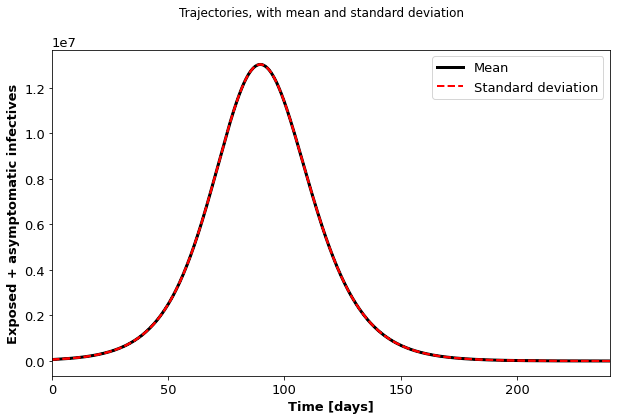

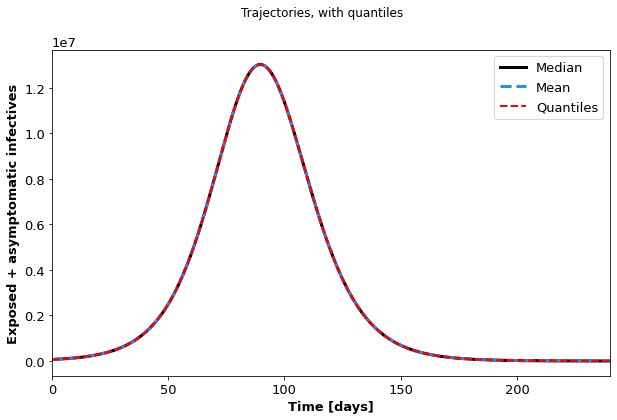

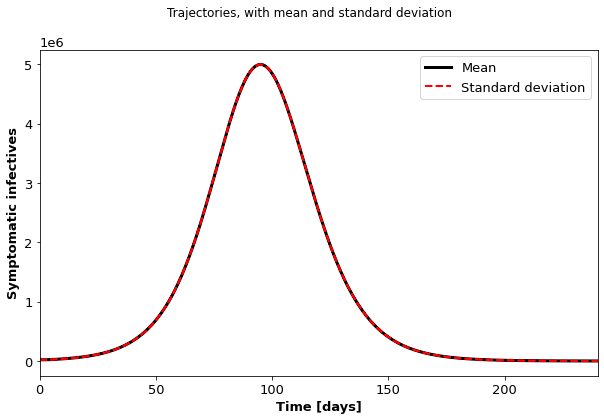

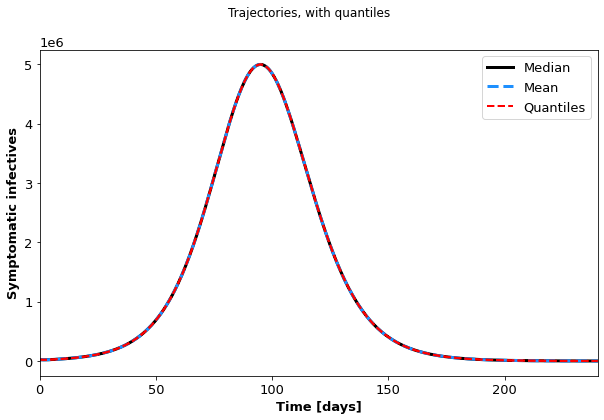

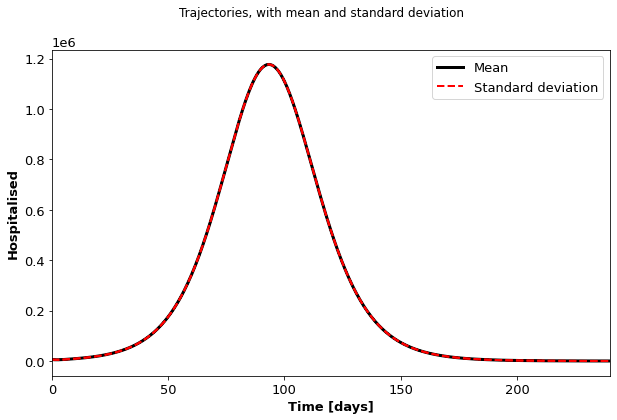

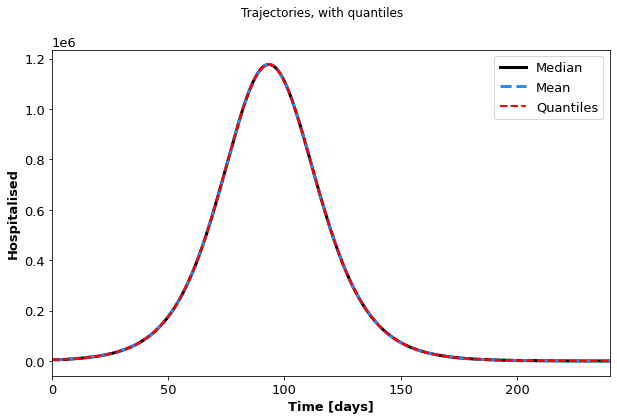

In [290]:
plot_data(t_s,
          trajectories = trajectories_E_A_Ia,
          mean = mean_E_A_Ia,  std =std_E_A_Ia,
         median = percentiles_median_E_A_Ia, 
          percentiles_lower =percentiles_lower_E_A_Ia, percentiles_upper =percentiles_upper_E_A_Ia,
         ylabel=r'Exposed + asymptomatic infectives')


print("\n\n")
plot_data(t_s,
          trajectories = trajectories_Is,
          mean = mean_Is,  std =std_Is,
         median = percentiles_median_Is, 
          percentiles_lower =percentiles_lower_Is, percentiles_upper =percentiles_upper_Is,
         ylabel=r'Symptomatic infectives')


print("\n\n")
plot_data(t_s,
          trajectories = trajectories_Ih,
          mean = mean_Ih,  std =std_Ih,
         median = percentiles_median_Ih, 
          percentiles_lower =percentiles_lower_Ih, percentiles_upper =percentiles_upper_Ih,
         ylabel=r'Hospitalised')

# 3 - Run inference on the first n days

## 3.1 - Create array with first n days of data

In [254]:
Tf_inf = 20;                         # using data for first 20 days
Nf_inf = Tf_inf + 1
N = NZA
data_inf = (data_array/N)[:Nf_inf]


# Do NOT run below

In [255]:
break

SyntaxError: 'break' outside loop (<ipython-input-255-6aaf1f276005>, line 1)

## 3.2 - Parameters for inference

In [308]:
ftol = 1e-1 
steps = 5
fi = np.array([0.25, 0.75])     # fraction of population in age age group
#
# initialise the estimator 
#

estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)


AttributeError: module 'pyross.inference' has no attribute 'SEAI5R'

In [260]:
# initial
alpha_g      = 0.15
alpha_std    = 0.2
alpha_bounds = (1e-3, 0.5)

beta_g      = 0.05
beta_std    = 0.1 
beta_bounds = (1e-3, 1)

gIa_g      = 0.13
gIa_std    = 0.1 
gIa_bounds = (1e-3, 1)

gIs_g      = 0.15
gIs_std    = 0.1 
gIs_bounds = (1e-3, 1)

guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std])
bounds = np.array([alpha_bounds , beta_bounds , gIa_bounds , gIs_bounds])
keys = ['alpha', 'beta', 'gIa', 'gIs']

params = estimator.infer_parameters(keys, guess, stds, bounds, data_inf, Tf_inf , Nf_inf , contactMatrix ,
                                    global_max_iter=20, global_ftol_factor = 10, verbose=True)

print(params)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=1756407618, Mon Jun  1 17:17:55 2020)


ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -7.617495532779282e+00 1.0e+00 1.01e+00  9e-02  2e-01 0:02.7


ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



    2     32 -8.862650995403641e+00 1.2e+00 8.63e-01  7e-02  2e-01 0:05.9


ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



    3     48 -8.057224333271085e+00 1.3e+00 7.83e-01  6e-02  1e-01 0:09.1


ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



    5     80 -8.608803806473700e+00 1.5e+00 6.68e-01  4e-02  1e-01 0:14.6


ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



    7    112 -8.748726847195586e+00 1.8e+00 5.11e-01  3e-02  6e-02 0:20.8


ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



    9    144 -9.048975142003764e+00 1.7e+00 3.75e-01  2e-02  3e-02 0:26.9


ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



   11    176 -8.905644449975075e+00 2.5e+00 2.98e-01  1e-02  2e-02 0:33.3


ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



   14    224 -9.132044189846006e+00 3.2e+00 2.27e-01  7e-03  2e-02 0:43.3


ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



   17    272 -9.174541244621443e+00 4.5e+00 2.38e-01  7e-03  2e-02 0:52.8


ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



Optimal value (global minimisation):  -9.22576870297606
Starting local minimisation...


ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4

ERROR:root:Internal Python error in the inspect module.
Below is

Traceback (most recent call last):
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ValueError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1148, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/IPython/core/ultratb.py", line 316, in wrapped
    return f(*args, **kwargs)
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/IPython/core/ultratb.py", line 350, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/inspect.py", line 1503,

ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



ValueError: 0-th dimension must be fixed to 12 but got 4


Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 1310, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "pyross/inference.pyx", line 1481, in pyross.inference.SIR_type.integrate
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py", line 577, in solve_ivp
    message = solver.step()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py", line 182, in step
    success, message = self._step_impl()
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py", line 148, in _step_impl
    solver._y, solver.t = integrator.run(
  File "/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/integrate/_ode.py", line 1343, in run
    y1, t, istate = self.runner(*args)
ValueError: 0-th dimension must be fixed to 12 but got 4



Optimal value (local minimisation):  -9.25189110959298
[0.03164046 0.00445346 0.06412636 0.08490809]
